In [15]:
%pylab inline
inDir="/home/oliver/GibbsChem/"

Populating the interactive namespace from numpy and matplotlib


/home/oliver/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Assumptions

- We are ignoring the post-birth changes in abundance. i.e. not using heavy element corrections - include these?

## Read in age table

Taking ages from Ness+16 i.e. http://iopscience.iop.org/article/10.3847/0004-637X/823/2/114/meta#apj523069t1

NB: Some of these ages exceed the age of the universe - we remove any with age > 12 Gyr and with $\chi^2<2$

In [60]:
# Define datatype
dtype={'names': ('ID', 'log_age', 'chi2', 'log_err_age'),'formats': ('S18', 'f8', 'f8','f8')}

table=np.loadtxt(inDir+"apj523069t1_mrt.txt",skiprows=39,usecols=[1,7,8,15],dtype=dtype)

Now filter to take well fitted ages only and pick sample size (as in Chempy paper)

In [86]:
chi_filter = np.where((table['chi2']>2.))
filt1=table[chi_filter]
age_filt = np.where(filt1['log_age']<np.log(12.))
filt2 = filt1[age_filt]

In [89]:
# Define some random subset of 100 (save this filtering for posterity):
N=100
random_indices = np.random.choice(range(len(filt_table)),100)
#np.save('RandomIndices.npy',random_indices)
random_indices=np.load('RandomIndices.npy')

In [90]:
# Pick 100 random samples from this table
filt_table=filt2[random_indices]
ID_labels=filt_table['ID']
log_ages = filt_table['log_age'] # ln(stellar age in Gyr)
log_age_errs = filt_table['log_err_age'] # uncertainty in ln(Age)

Now save the output

In [91]:
with open(inDir+'apogee_ages_IDs.txt',"w+") as outfile:
    for ID in ID_labels:
        outfile.write("%s\n" %ID)

## Extract Data

Dataset is here: https://dr12.sdss.org/infrared/spectrum/view/

We use the ASPCAP abundances from APOGEE using DR12 for consistency with ages.

Description of fits files is here (but only applies to DR14 not this DR12): https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/LOCATION_ID/aspcapStar.html

## NB:

Format of abundances (see https://www.sdss.org/dr12/irspec/abundances/):

If using uncalibrated FELEM:
- (C, N, O, Mg, Si, S, Ca, Ti) are given as [X/M] abundances (i.e. relative to solar-scaled metallicity)
- (Na, Al, K, V, Mn, Fe, Ni) are given as [X/H] abundances

If using calibrated ELEM (as here):
- All are given as [X/H] abundances (i.e. relative to solar-scaled metallicity)

**Thus we must convert to [X/Fe] abundances**

In [92]:
# Define element ordering:
abundance_names = np.asarray(["C","N","O","Na","Mg","Al","Si","S","K","Ca","Ti","V","Mn","Fe","Ni"])

In [93]:
specDir=inDir+'dr12/'
from astropy.io import fits
X_H_list = np.zeros([N,15])
X_H_err=np.zeros([N,15])

for i,ID in enumerate(ID_labels):
    name = 'aspcapStar-r5-v603-%s.fits'%ID
    
    # Now load fits file
    hdul = fits.open(specDir+name)  # open a FITS file
    data = hdul[4].data  # assume the first extension is a table
    
    # Calibrated Abundances are from the DR12 FERRE fits in the order defined below
    X_H_list[i]=data['ELEM'][0]
    X_H_err[i]=data['ELEM_ERR'][0]

** Convert these to [X/Fe] ratios**. NB: [Fe/H] remains relative to H here.

We here add the [X/H] and [Fe/H] errors in quadrature. This generally overestimates the error, since it does not take into account correlated errors.

In [94]:
Fe_index = np.where(abundance_names=='Fe')[0]
X_Fe_abun=np.zeros_like(X_H_list)
X_Fe_err=np.zeros_like(X_H_list)
for j in range(len(abundance_names)):
    for i in range(len(ID_labels)):
        if j!=Fe_index:
            ## Subtract [Fe/H] from each
            X_Fe_abun[i,j]=X_H_list[i,j]-X_H_list[i,Fe_index]
            ## Add errors in quadrature
            X_Fe_err[i,j]=np.sqrt(X_H_err[i,j]**2.+X_H_err[i,Fe_index]**2.)
        else: # for [Fe/H] case
            X_Fe_abun[i,j]=X_H_list[i,j]
            X_Fe_err[i,j]=X_H_err[i,j]

** Save to file**

In [95]:
np.savez('APOGEE_dataset.npz',abun=X_Fe_abun,abun_err=X_Fe_err,ln_age=log_ages,ln_age_err=log_age_errs)

Now compute the range of ages in the sample (needed for network training):

In [96]:
print("Min age: %.2f Gyr, Max age: %.2f Gyr" %(min(np.e**log_ages),max(np.e**log_ages)))

Min age: 0.86 Gyr, Max age: 11.88 Gyr


In [97]:
print("Min log age: %.2f, Max log age: %.2f" %(min(log_ages),max(log_ages)))

Min log age: -0.15, Max log age: 2.48


(array([ 3.,  0.,  3.,  5.,  3., 10., 20., 12., 25., 19.]),
 array([-0.14831 ,  0.114031,  0.376372,  0.638713,  0.901054,  1.163395,
         1.425736,  1.688077,  1.950418,  2.212759,  2.4751  ]),
 <a list of 10 Patch objects>)

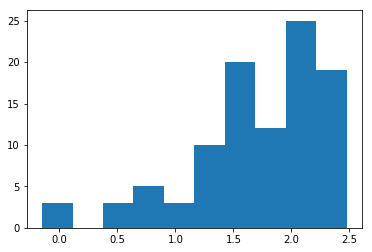

In [102]:
plt.hist(log_ages)

<ErrorbarContainer object of 3 artists>

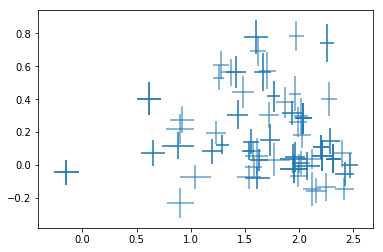

In [99]:
plt.errorbar(log_ages,X_Fe_abun[:,1],yerr=X_Fe_err[:,1],xerr=log_age_errs,linestyle='',alpha=0.7)